In [1]:
# Importing necessary libraries for the analysis.
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import csv
import math
import json
from scipy.ndimage import uniform_filter1d
from tqdm import tqdm
import pandas as pd, datetime
import time
import cartopy.crs as ccrs

from utils import *
from diffusion_networks import *
from sampler import *
from calculations import *
from loss import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cmap_z = plt.cm.get_cmap('viridis', 30) #z500
cmap_t = plt.cm.get_cmap('hot', 30)     #t850

# **Data Loading**

## WB

In [3]:
# Variables
mean_data = []
std_data = []

# Geopotential 500hPa
fname= 'geopotential_500hPa_1979-2018_5.625deg.npy'
mean_geopotential500 = 54112.887 
std_geopotential500 = 3354.9524

mean_data.append(mean_geopotential500)
std_data.append(std_geopotential500)

# Temperature 850hPa
mean_temperature850 = 274.5266
std_temperature850 = 15.5915

fname= 'temperature_850hPa_1979-2018_5.625deg.npy'
mean_data.append(mean_temperature850)
std_data.append(std_temperature850)

fname= 'z500_t850_1979-2018_5.625deg.npy'

vars = len(mean_data)

mean_data = torch.tensor(mean_data)
std_data = torch.tensor(std_data)

norm_factors = np.stack([mean_data, std_data], axis=0)

### Hurricane season

In [19]:
# Loading data for scrolling
data = np.load(fname)
climatology = np.mean(data, axis=0)

In [43]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import interact, IntSlider, Play, VBox, jslink, Dropdown
from IPython.display import display

ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')

# Update the show_image function to use plot_global
def show_image(index, var_ch, cmap_z):

    fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.Robinson()})
    ax.set_title(f'{ti[index]} - Channel {var_ch}')
    cf = ax.pcolormesh(lon, lat, data[index, var_ch], transform=ccrs.PlateCarree(), cmap=cmap_z)
    ax.coastlines(resolution='110m')
    #ax.gridlines()
    cb = plt.colorbar(cf, shrink=0.5)
    plt.show()
    
# Create a play widget to automatically slide through the images
play = Play(
    value=0,
    min=0,
    max=data.shape[0] - 1,
    step=1,
    interval=100,  # Interval in milliseconds (adjust this to control speed)
    description="Play",
    disabled=False
)

# Create a slider linked to the play widget
slider = IntSlider(min=0, max=data.shape[0] - 1, step=1, value=0, description='Image Index')

# Link the play widget and the slider
jslink((play, 'value'), (slider, 'value'))

# Create a dropdown to select the colormap
cmap_dropdown = Dropdown(
    options=[cmap_z, cmap_t],
    value=cmap_z,
    description='Colormap'
)

# Create a slider to select the channel (for multi-channel data)
channel_slider = IntSlider(min=0, max=data.shape[1] - 1, step=1, value=0, description='Channel')

# Create an interactive plot
interact_plot = interact(show_image, index=slider, var_ch=channel_slider, cmap_z=cmap_dropdown)

# Combine the play, slider, channel slider, and colormap dropdown in a vertical box layout
controls = VBox([play, slider, channel_slider, cmap_dropdown])

# Display the controls and plot together
display(controls, interact_plot)
pass


interactive(children=(IntSlider(value=0, description='Image Index', max=350639), IntSlider(value=0, descriptio…

<function __main__.show_image(index, var_ch, cmap_z)>

In [20]:
from ipywidgets import interact, IntSlider, Play, VBox, jslink, Dropdown
from IPython.display import display
import datetime

# Create the time index
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')

# Update the show_image function to use plot_global
def show_image(year, hour_in_year, var_ch, cmap_z):
    # Calculate the global index from the year and hour_in_year
    start_of_year = pd.Timestamp(year=year, month=1, day=1, hour=0)
    index = ti.get_loc(start_of_year) + hour_in_year

    fig, ax = plt.subplots(1, 1, figsize=(15,10), subplot_kw={'projection': ccrs.Robinson()})
    ax.set_title(f'{ti[index]} - Channel {var_ch}')
    #cf = ax.pcolormesh(lon, lat, data[index, var_ch] - climatology[var_ch], transform=ccrs.PlateCarree(), cmap=cmap_z)
    cf = ax.pcolormesh(lon, lat, data[index, var_ch], transform=ccrs.PlateCarree(), cmap=cmap_z)
    ax.coastlines(resolution='110m')
    #ax.gridlines()
    cb = plt.colorbar(cf, shrink=0.5)
    plt.show()

# Year Slider (rough scale)
year_slider = IntSlider(min=1979, max=2018, step=1, value=2018, description='Year')

# Hour Slider (fine-tuning within the selected year)
hour_slider = IntSlider(min=0, max=8760 - 1, step=6, value=6024, description='Hour in Year')

# Update the hour slider limits dynamically based on the selected year
def update_hour_slider_limits(*args):
    year = year_slider.value
    # Adjust max based on whether it's a leap year
    if year % 4 == 0 and (year % 100 != 0 or year % 400 == 0):
        hour_slider.max = 8784 - 1  # Leap year (366 days)
    else:
        hour_slider.max = 8760 - 1  # Common year (365 days)

# Link the update function to the year slider
year_slider.observe(update_hour_slider_limits, names='value')

# Create a dropdown to select the colormap
cmap_dropdown = Dropdown(
    options=[cmap_z, cmap_t],
    value=cmap_z,
    description='Colormap'
)

# Create a slider to select the channel (for multi-channel data)
channel_slider = IntSlider(min=0, max=data.shape[1] - 1, step=1, value=0, description='Channel')

# Create an interactive plot
interact_plot = interact(show_image, year=year_slider, hour_in_year=hour_slider, var_ch=channel_slider, cmap_z=cmap_dropdown)

# Combine the controls in a vertical box layout
controls = VBox([year_slider, hour_slider, channel_slider, cmap_dropdown])

# Display the controls and plot together
display(controls, interact_plot)


interactive(children=(IntSlider(value=2018, description='Year', max=2018, min=1979), IntSlider(value=6024, des…

<function __main__.show_image(year, hour_in_year, var_ch, cmap_z)>

In [75]:
for previous, current, time_label in test_time_series_loader:
        break
    

347928


## Data

In [4]:
# WB Dataset
batch_size = 32
max_lead_time = 24*10# 24*10
dt = 6

initial_times = [0, -dt]

lead_time_range = [dt, max_lead_time, dt]

spacing = 1
spinup = 0
ti = pd.date_range(datetime.datetime(1979,1,1,0), datetime.datetime(2018,12,31,23), freq='1h')
n_train = sum(ti.year <= 2015)
n_val = sum((ti.year >= 2016) & (ti.year <= 2017))

# TEST
#end_date = datetime.datetime(2018, 9, 12, 0)
#n_val = sum((ti.year >= 2016) & (ti < end_date))

n_samples = len(ti)
sample_counts = (n_samples, n_train, n_val)

subd = '/proj/berzelius-2022-164/users/sm_maran/data/wb'
dataset_path = Path(f'{subd}/{fname}')

grid_dimensions = (vars, 32, 64)

offset = 2**7

WB_kwargs = {
            'dataset_path':     dataset_path,
            'sample_counts':    sample_counts,
            'dimensions':  grid_dimensions,
            'max_lead_time':    max_lead_time,
            'norm_factors':     norm_factors,
            'device':           device,
            'spinup':           spinup,
            'spacing':          spacing,
            'dtype':            'float32',
            'offset':           offset,
            'initial_times':    initial_times,
            'lead_time_range':  lead_time_range,
            }

kwargs = WB_kwargs

In [5]:
# Way to load a dataset with a specific lead time
lead_time = max_lead_time
train_dataset = QGDataset(lead_time=lead_time,dataset_mode='train', **WB_kwargs)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **WB_kwargs)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


# Way to load a dataset with lead time following a distribution given by update_k_per_batch
kmin = dt
kmax = max_lead_time
d = dt

update_k_per_batch = get_uniform_k_dist_fn(kmin, kmax, d)

train_time_dataset = QGDataset(lead_time=kmax, dataset_mode='train', **WB_kwargs)
train_batch_sampler = DynamicKBatchSampler(train_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
train_time_loader = DataLoader(train_time_dataset, batch_sampler=train_batch_sampler)

val_time_dataset = QGDataset(lead_time=max_lead_time, dataset_mode='val', **WB_kwargs)
val_batch_sampler = DynamicKBatchSampler(val_time_dataset, batch_size=batch_size, drop_last=True, k_update_callback=update_k_per_batch, shuffle=True)
val_time_loader = DataLoader(val_time_dataset, batch_sampler=val_batch_sampler)


# Way to load a single trajectory. Only uses 1 batch.

k_series = kmin + d * np.arange(0, 1 + (kmax-kmin)//d)

val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **WB_kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

test_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='test', **WB_kwargs)
test_time_series_loader = DataLoader(test_time_series_dataset, batch_size=1, shuffle=False)

In [6]:
precomputed_std = []

res_std_geopotential500 = torch.tensor(np.loadtxt('stds/WB_z500.txt',delimiter=' ')[:,1], dtype=torch.float32).to(device)
res_std_geopotential500 = res_std_geopotential500
precomputed_std.append(res_std_geopotential500)

res_std_temperature850 = torch.tensor(np.loadtxt('stds/WB_t850.txt',delimiter=' ')[:,1], dtype=torch.float32).to(device)
precomputed_std.append(res_std_temperature850)

precomputed_std = torch.stack([res_std for res_std in precomputed_std], axis=1)

precomputed_std = precomputed_std[:max_lead_time]
# Old
#def residual_scaling(x):
#    return precomputed_std[x.to(dtype=int)-1][None, :, None, None]

def residual_scaling(x):
    if x.ndim == 0:
        x = x.unsqueeze(0)  
    indices = x.to(dtype=int) - 1
    
    return precomputed_std[indices].view(x.shape[0], vars, 1, 1)

In [7]:
fnm_ll = f'{subd}/latlon_500hPa_1979-2018_5.625deg.npz'
buf = np.load(fnm_ll)
lat, lon = buf['arr_0'], buf['arr_1']

wmse = AreaWeightedMSELoss(lat, lon, device)

wmse_plot = calculate_AreaWeightedRMSE(lat, lon, device).diff
calculate_WRMSE = calculate_AreaWeightedRMSE(lat, lon, device).calculate
calculate_WSkill = calculate_AreaWeightedRMSE(lat, lon, device).skill
calculate_WSpread = calculate_AreaWeightedRMSE(lat, lon, device).spread

In [8]:
mean_data = mean_data.to(device)
std_data = std_data.to(device)
def renormalize(x, mean_ar=mean_data, std_ar=std_data):
    x = x * std_ar[None, :, None, None] + mean_ar[None, :, None, None]
    return x

## Scaling function

In [ ]:
def calculate_latent_mean_std():
    # Calculate mean and var
    # Initialize variables for mean and standard deviation
    mean_data_latent = 0.0
    std_data_latent = 0.0
    count = 0
    #autoencoder.to('cpu')
    # Iterate over the batches in train_loader
    #autoencoder.eval()
    with torch.no_grad():
        for current, next,_ in train_loader:
            # Get the input data from the batch
            current = current.to(device)
            next = next.to(device)
            #latent = autoencoder.encoder(current)
            #next_latent = autoencoder.encoder(next)

            #inputs = next_latent -  latent
            inputs = next - current
            count += inputs.size(0)

            # Calculate the sum of the input data
            mean_data_latent += torch.sum(inputs)
            std_data_latent += torch.sum(inputs ** 2)
            #print(mean_data_latent/count, std_data_latent/count, count)
            break
            
        # Calculate the mean and standard deviation
        count = count * inputs[0].cpu().detach().numpy().size
        # TODO
        mean_data_latent /= count
        std_data_latent = torch.sqrt(std_data_latent / count - mean_data_latent ** 2)

        # Print the mean and standard deviation
        #print("Mean:", mean_data_latent.item())
        #print("Standard Deviation:", std_data_latent.item())

    return mean_data_latent, std_data_latent

mean_data_latent, std_data_latent = calculate_latent_mean_std()
print(mean_data_latent, std_data_latent)

In [ ]:
# Way to load a dataset with a specific lead time
lead_time = 121
train_dataset = QGDataset(lead_time=lead_time,dataset_mode='train', **kwargs)
train_loader = DataLoader(train_dataset, batch_size=4000, shuffle=True)

max_lead_time=24*10
# Fit the residual scaling
ks = np.arange(lead_time, max_lead_time+1, 1)
stds = []
for k in ks:
    train_dataset.set_lead_time(k)

    mean_k, std_latent_k = calculate_latent_mean_std()
    stds.append(std_latent_k.item())
    print(k, mean_k.item(),std_latent_k.item())

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Load the data from the file
data = np.loadtxt('test.txt')

# Extracting columns
index = data[:, 0]
values = data[:, 1]
time = data[:, 2]

# Plotting the data
plt.figure(figsize=(10, 6))

# Plot values against time
plt.plot(index, time, label='Values', marker='o')

# Adding labels and title
plt.xlabel('Time (or Step)')
plt.ylabel('Values')
plt.title('Plot of Values vs. Time')
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
file_path = "stds/wb-copy.txt"
# Generating the content for stds.txt
stds_content = "\n".join([f"{ks[i]} {std}" for i, std in enumerate(stds)])

# Writing the content to stds.txt
with open(file_path, "a") as file:
    file.write(stds_content)

In [ ]:
x = ks[:]
y = stds[:]


# Plotting the original data and the fitted models
plt.figure(figsize=(12, 8))
plt.scatter(x, y, color='blue', label='Data points', marker='.')
#plt.plot(x, y_fitted_log, color='red', label='Log Model')
#plt.plot(x, y_fitted_logistic, color='green', label='Logistic Model')
plt.title('Data Points with Fitted Models')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.show()


# **Diffusion**

In [9]:
# Generation

def generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        class_labels = previous_unbatched.repeat(n_ens, 1, 1, 1)
        
        previous_state = previous_unbatched[:,:vars]
        latents = torch.randn_like(previous_state.repeat(n_ens, 1, 1, 1), device=device)
        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_state = predicted_residuals #* residual_scaling(time_label[0]) + previous_state

        predicted = predicted_state.to(torch.float32)

        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current_unbatched)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current_unbatched.size(0), current_unbatched.size(1), current_unbatched.size(2), current_unbatched.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_ensemble_from_batch(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))
    lead_time = time_labels[0].item()

    with torch.no_grad():
        previous = previous.to(device)
        current = current.to(device)
        previous_state = previous[:,:vars].repeat(n_ens, 1, 1, 1)

        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time

        latents = torch.randn_like(previous_state, device=device)
        
        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = predicted_residuals# * residual_scaling(torch.tensor(lead_time)) + previous_state
        
        predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))

    return predicted_unnormalized, current_unnormalized

def generate_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars]#.repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        latents = latents.repeat_interleave(current.shape[0], dim=0)


        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

In [10]:
def generate_ar_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        #previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)
        previous_state = previous[:,:vars]#.repeat(n_ens, 1, 1, 1)
        #class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = time_labels.flatten()[0].to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        # Test
        latent_shape = latents.shape
        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(current.shape[0]):
            latents = torch.randn(latent_shape, device=device)
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, 
                                             sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            predicted_latent = predicted_residuals #* residual_scaling(time_labels) + previous_state
            predicted = predicted_latent

            #previous_state = predicted
            predicted_combined[:, i] = predicted

            class_labels = torch.cat((predicted, class_labels[:,:vars]), dim=1)
            
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

In [11]:
def generate_det_forecast_from_batch(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))
    lead_time = time_labels[0].item()

    with torch.no_grad():
        previous = previous.to(device)
        current = current.to(device)
        previous_state = previous[:,:vars].repeat(n_ens, 1, 1, 1)

        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time
        
        predicted = model(class_labels, time_labels)
                
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))

    return predicted_unnormalized, current_unnormalized

def generate_det_forecast_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        #latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        #latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        predicted = model(class_labels, time_labels/max_lead_time)
        #predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        #predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        #predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_ar_det_forecast_from_time_series(model, n_ens=1, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        #previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)
        previous_state = previous[:,:vars]#.repeat(n_ens, 1, 1, 1)
        #class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = time_labels.flatten()[0].to(device).repeat(n_ens)

        #latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        #latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(current.shape[0]):
            predicted = model(class_labels, time_labels/max_lead_time)
            #predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            #predicted_latent = predicted_residuals #* residual_scaling(time_labels) + previous_state
            #predicted = predicted_latent

            predicted_combined[:, i] = predicted

            class_labels = predicted#torch.cat((predicted, class_labels[:,:vars]), dim=1)
            
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_det_forecast_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        #latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        #latents = torch.randn(latent_shape, device=device)
        #latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        predicted = model(class_labels, time_labels/ max_lead_time)
        #predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        #predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        #predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized


## **Training**

### Deterministic

In [13]:
# Setup for training

forecasting = True

filters = 32
model_type='large'

num_epochs = 10
input_times = (len(initial_times)) * vars

model = DetPrecond(filters=filters, img_channels=input_times, out_channels=vars, img_resolution = 64, model_type=model_type)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

loss_fn = WMSELoss(lat, lon, device)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'results/training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])


Num params:  3543778


In [14]:
model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-02/z500_t850_f32_IC[0 -6]_dt6_240_state_residual_deterministic/best_model.pth'))

#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-02/z500_t850_f32_IC[0]_dt1_state_residual_deterministic/best_model.pth'))


<All keys matched successfully>

In [12]:
log_interval = len(train_loader) // 10

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    current_loss = 0
    count = 0

    for previous, current, time_label in tqdm(train_time_loader):
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous
            target_latent = (current_latent)# - previous_state) / residual_scaling(time_label[0])
            
        loss = loss_fn(model, target_latent, class_labels, time_label/max_lead_time)
         
        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            current_loss = current_loss / count
            print(f'Average Loss: {current_loss:.4f}')
            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_time_loader):
            current = current.to(device)
            previous = previous.to(device)
            time_label = time_label.to(device)
            
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous

            target_latent = (current_latent)# - previous_state) / residual_scaling(time_label[0])
            
            loss = loss_fn(model, target_latent, class_labels, time_label/max_lead_time)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'results/best_model.pth')
    
    scheduler.step()
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(model.state_dict(), 'final_model.pth')

    # Sampling phase 72h

# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

 10%|█████████▍                                                                                    | 254/2532 [01:00<05:58,  6.36it/s]

Average Loss: 469.5586


 20%|██████████████████▊                                                                           | 507/2532 [01:38<04:57,  6.80it/s]

Average Loss: 83.6191


 30%|████████████████████████████▏                                                                 | 760/2532 [02:14<04:06,  7.19it/s]

Average Loss: 71.9638


 40%|█████████████████████████████████████▏                                                       | 1013/2532 [02:49<03:32,  7.15it/s]

Average Loss: 63.3293


 50%|██████████████████████████████████████████████▌                                              | 1266/2532 [03:24<02:52,  7.33it/s]

Average Loss: 56.7891


 58%|█████████████████████████████████████████████████████▉                                       | 1470/2532 [03:52<02:47,  6.33it/s]


KeyboardInterrupt: 

### Diffusion

In [12]:
# Setup for training

forecasting = True

filters=32
model_type='large'

num_epochs = 10
input_times = (1 + len(initial_times)) * vars

model = EDMPrecond(filters=filters, img_channels=input_times, out_channels=vars, img_resolution = 64, 
                   time_emb=1, model_type=model_type, sigma_data=1, sigma_min=0.02, sigma_max=88)
print("Num params: ", sum(p.numel() for p in model.parameters()))

model.to(device)
 
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

loss_fn = WGCLoss(lat, lon, device, precomputed_std=precomputed_std)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
warmup_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=1.0, total_iters=1000)
loss_values = []
val_loss_values = []
best_val_loss = float('inf')

# Setup for logging
log_file_path = 'results/training_log.csv'
with open(log_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the header
    writer.writerow(['Epoch', 'Average Training Loss', 'Validation Loss'])


Num params:  3545506


In [13]:
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_IC[0, -6]_dt6_state_residual_single-step/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_IC[0, -6]_dt6_state_residual_single-step_scaler/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_wd-1_IC[0 -6]_dt6_state_residual/best_model.pth'))

# Current interesting
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale/best_model.pth'))
model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale_rand-dt/best_model.pth'))
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-04/z500_t850_f32_IC[0, -6]_dt6_state_residual_res-scale_rand-dt-scheduled/final_model.pth'))


# Att träna
# Alla residual
# dt1 med [0 -1 -2 -3] t120
# dt1 med [0 -1 -2 -3] single step


# Only one with dt1 residual (120h)
#model.load_state_dict(torch.load('/proj/berzelius-2022-164/users/sm_maran/results/2024-09-01/z500_t850_f32_wd-1_IC[0 -1]_dt1_state_residual/best_model.pth'))

model.to(device)
pass

In [ ]:
log_interval = len(train_loader) // 5

for epoch in range(num_epochs):
    lead_time_range = [dt, int(dt * (1 + 240*epoch/num_epochs//dt)), dt]
    train_time_loader.dataset.set_lead_time_range(lead_time_range)
    model.train()
    total_train_loss = 0
    current_loss = 0
    count = 0

    for previous, current, time_label in tqdm(train_time_loader):
        print(time_label)
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        count += 1
        optimizer.zero_grad()
        
        with torch.no_grad():
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous
            target_latent = (current_latent - previous_state) / residual_scaling(time_label[0])
            
        loss = loss_fn(model, target_latent, class_labels, time_label/max_lead_time)
         
        total_train_loss += loss.item()
        current_loss += loss.item()

        loss.backward()
        optimizer.step()

        if count % log_interval == 0:
            current_loss = current_loss / count
            print(f'Average Loss: {current_loss:.4f}')
            current_loss = 0
            count = 0
        
        warmup_scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)

    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for previous, current, time_label in tqdm(val_loader):
            current = current.to(device)
            previous = previous.to(device)
            time_label = time_label.to(device)
            
            current_latent = current
            previous_state = previous[:,:vars]
            class_labels = previous

            target_latent = (current_latent - previous_state) / residual_scaling(time_label[0])
            
            loss = loss_fn(model, target_latent, class_labels, time_label/max_lead_time)
            
            total_val_loss += loss.item()
            
    avg_val_loss = total_val_loss / len(val_loader)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'results/best_model.pth')
    
    scheduler.step()
    
    # Log to CSV    
    loss_values.append([avg_train_loss])
    val_loss_values.append(avg_val_loss)
    
    # Log to CSV
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([epoch+1, avg_train_loss, avg_val_loss])
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    torch.save(model.state_dict(), 'final_model.pth')

    # Sampling phase 72h
    ## Val
    forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)
    wrmse = calculate_WRMSE(forecast, truth)
    skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
    crps = calculate_CRPS(forecast, truth)
    print(f'Val\t: WRMSE: {np.mean(wrmse.flatten()):0f}, +- {np.std(wrmse.flatten()):0f}')
    #print(f"Val\t: WRMSE: {wrmse[0][0]:.2f}, Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}")

    ## Train
    forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = train_loader, sampler_fn=heun_sampler)
    wrmse = calculate_WRMSE(forecast, truth)
    skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
    crps = calculate_CRPS(forecast, truth)
    print(f'Train\t: WRMSE: {np.mean(wrmse.flatten()):0f}, +- {np.std(wrmse.flatten()):0f}')
    #print(f"Train\t: WRMSE: {wrmse[0][0]:.2f}, Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}")


# Plotting
plt.figure(figsize=(10, 6))
loss_plot = np.array(loss_values)
plt.plot(loss_plot[1:], label='Training Loss', color='blue')

plt.plot(val_loss_values[1:], label='Validation Loss', color='red')
plt.title('Loss as a Function of Epochs')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.grid(True)
plt.legend()
plt.show()

## Evaluating

In [ ]:
model.eval()
total_val_loss = 0
with torch.no_grad():
    for previous, current, time_label in tqdm(val_time_loader):
        
        current = current.to(device)
        previous = previous.to(device)
        time_label = time_label.to(device)
        
        current_latent = current
        class_labels = previous
        previous_target = previous[:,:vars]

        target_latent = (current_latent - previous_target) / residual_scaling(time_label[0])
        
        loss = loss_fn(model, target_latent, class_labels, time_label/max_lead_time)
        total_val_loss += loss.item()
        
avg_val_loss = total_val_loss / len(val_time_loader)
avg_val_loss

In [ ]:
cmap_z = plt.cm.get_cmap('viridis')     #t850
cmap_t = plt.cm.get_cmap('hot')     #t850

# Assuming `truth`, `forecast`, and `previous` are tensors or numpy arrays

tim = 1

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10,5))
# Plot the first image
axs[0, 0].imshow(target_latent[tim, 0].cpu(), cmap_z)  # Add cmap if necessary
axs[0, 0].axis('off')  # Remove axis labels
axs[0,0].set_title('Residual')


# Plot the second image
axs[0, 1].imshow(((current_latent[tim, 0])).cpu(),cmap_z)  # Add cmap if necessary
axs[0, 1].axis('off')  # Remove axis labels
axs[0, 1].set_title('Truth')

# Plot the third image
axs[1, 0].imshow((target_latent[tim,1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 0].axis('off')  # Remove axis labels

# Plot the fourth image (commented out in your code)
# If you want to add it back, uncomment the following lines:
axs[1, 1].imshow((current_latent[tim, 1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 1].axis('off')  # Remove axis labels

# If you don't want to include the fourth image, remove the axis altogether
#fig.delaxes(axs[1, 1])
#fig.delaxes(axs[1, 0])

# Show the plot
plt.show()


In [ ]:
# Way to load a dataset with a specific lead time
lead_time = max_lead_time
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **WB_kwargs)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
target_time = 24*5

train_dataset.set_lead_time(target_time)
val_dataset.set_lead_time(target_time)

# Sampling phase 72h
forecast, truth, previous = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)
wrmse = calculate_WRMSE(forecast, truth)
skill = calculate_WSkill(forecast, truth)
spread = calculate_WSpread(forecast, truth)


for channel in range(wrmse.shape[-1]):  # Loop over the last dimension (channels)calculate_WSkill(forecast, truth_plot)
    print(f'Channel {channel + 1}:')
    print(f'{target_time}h - WRMSE: {np.mean(wrmse[..., channel].flatten()):.2f}, '
          f'Skill: {np.mean(skill[..., channel].flatten()):.2f}, '
          f'Spread: {np.mean(spread[..., channel].flatten()):.2f}')

In [ ]:
val_dataset.set_lead_time(24*3)
forecast, truth = generate_ensemble_from_batch(model, n_ens=3, selected_loader = val_loader, sampler_fn=heun_sampler)
wrmse_1 = calculate_WRMSE(forecast, truth)
skill_1 = calculate_WSkill(forecast, truth)
spread_1 = calculate_WSpread(forecast, truth)

val_dataset.set_lead_time(24*5)
forecast, truth = generate_ensemble_from_batch(model, n_ens=3, selected_loader = val_loader, sampler_fn=heun_sampler)
wrmse_2 = calculate_WRMSE(forecast, truth)
skill_2 = calculate_WSkill(forecast, truth)
spread_2 = calculate_WSpread(forecast, truth)

for channel in range(wrmse_1.shape[-1]):  # Loop over the last dimension (channels)
    print(f'Channel {channel + 1}:')
    print(f'  3d - WRMSE: {np.mean(wrmse_1[..., channel].flatten()):.2f}, '
          f'Skill: {np.mean(skill_1[..., channel].flatten()):.2f}, '
          f'Spread: {np.mean(spread_1[..., channel].flatten()):.2f}')
    print(f'  5d - WRMSE: {np.mean(wrmse_2[..., channel].flatten()):.2f}, '
          f'Skill: {np.mean(skill_2[..., channel].flatten()):.2f}, '
          f'Spread: {np.mean(spread_2[..., channel].flatten()):.2f}', flush=True)

In [ ]:
import matplotlib.pyplot as plt

cmap_z = plt.cm.get_cmap('viridis', 30)     #t850
cmap_t = plt.cm.get_cmap('hot', 30)     #t850


# Assuming `truth`, `forecast`, and `previous` are tensors or numpy arrays
ens_ch = 2
tim = 4

# Create a 2x2 subplot
fig, axs = plt.subplots(2, 2, figsize=(10,5))

# Plot the first image
axs[0, 0].imshow((truth[tim, 0]).cpu(),cmap_z)  # Add cmap if necessary
axs[0, 0].axis('off')  # Remove axis labels
axs[0,0].set_title('Truth')

# Plot the second image
axs[0, 1].imshow(((forecast[ens_ch, tim, 0])).cpu(),cmap_z)  # Add cmap if necessary
axs[0, 1].axis('off')  # Remove axis labels
axs[0, 1].set_title('Forecast')

# Plot the third image
axs[1, 0].imshow((truth[tim, 1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 0].axis('off')  # Remove axis labels

# Plot the fourth image (commented out in your code)
# If you want to add it back, uncomment the following lines:
axs[1, 1].imshow((forecast[ens_ch, tim, 1]).cpu(), cmap_t)  # Add cmap if necessary
axs[1, 1].axis('off')  # Remove axis labels

# If you don't want to include the fourth image, remove the axis altogether
#fig.delaxes(axs[1, 1])
#fig.delaxes(axs[1, 0])

# Show the plot
plt.show()


## **Generation**

In [ ]:
def OLD_generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = previous_unbatched

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)
        #latents = torch.randn_like(previous_latent, device=device).repeat(n_ens, 1, 1, 1)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = previous_latent + predicted_residuals * residual_scaling(time_label[0])

        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

def generate_ar_ensemble_from_single_random(model, rollout, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler):
    model.eval()

    for previous, current, time_label in selected_loader:
        time_labels = torch.ones(n_ens, device=device, dtype=int) * time_label[0]
        previous_unbatched = previous[0].unsqueeze(0).to(device)
        current_unbatched = current[0].unsqueeze(0).to(device)
        break
    
    with torch.no_grad():
        previous_latent = previous_unbatched

        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(time_label[0])
            
            class_labels = predicted_latent
        
        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data
        current_unnormalized = current_unbatched * std_data + mean_data
        previous_unnormalized = previous_unbatched * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, 1, previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized, current_unnormalized, previous_unnormalized

#predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ar_ensemble_from_single_random(model, rollout=2, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

def OLD_generate_ensemble_from_batch(model, previous, lead_time, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = previous
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time

        latents = torch.randn_like(class_labels, device=device)

        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

        predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time, n_ens=1)

def generate_ar_ensemble_from_batch(model, previous, lead_time, rollout, n_ens=10, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    with torch.no_grad():
        previous = previous.to(device)
        previous_latent = previous
        class_labels = previous_latent.repeat(n_ens, 1, 1, 1)
        time_labels = torch.ones(class_labels.shape[0], device=device, dtype=int) * lead_time / max_lead_time
        latents = torch.randn_like(class_labels, device=device)

        for i in range(rollout):
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)

            predicted_latent = class_labels + predicted_residuals * residual_scaling(torch.tensor(lead_time))
            
            class_labels = predicted_latent
        
        predicted = predicted_latent.to(torch.float32)

        predicted_unnormalized = predicted * std_data + mean_data

        predicted_unnormalized = predicted_unnormalized.view(n_ens, previous.size(0), previous.size(1), previous.size(2), previous.size(3))

    return predicted_unnormalized

#predicted_unnormalized = generate_ar_ensemble_from_batch(model, next(iter(val_loader))[0], lead_time=10, rollout=3, n_ens=1)

## **Evaluation**

### ***Calculations***

Batched input (n_ens, batch_size, img_channels, img_resolution, img_resolution)

In [ ]:
# This does work for unbatched data currently

forecast, truth, _ = generate_ensemble_from_single_random(model, n_ens=10, selected_loader = val_loader, sampler_fn=heun_sampler)

skill, spread, ratio = calculate_skill_and_spread_score(forecast, truth)
crps = calculate_CRPS(forecast, truth)
brier = calculate_brier_score(forecast, truth, 20)


print(f"Skill: {skill[0]:.2f}, Spread: {spread[0]:.2f}, Ratio: {ratio[0]:.3f}, CRPS: {crps[0]:.3f}, Brier: {brier[0]:.4f}")

In [ ]:
# To be relative to climatology we need it to be just for a single season.

clim = climatology * std_data + mean_data
calculate_RMSE(clim, truth)



In [ ]:
def evaluation_pipeline(model, n_ens=10, n_batches=1, batch_size=10, selected_loader=val_loader, sampler_fn=edm_sampler, rollouts=None):
    model.eval()

    #climatology = calculate_climatology(selected_loader)

    results = {
                'skill': np.zeros(n_batches*batch_size),
                'spread': np.zeros(n_batches*batch_size),
                'ratio': np.zeros(n_batches*batch_size),
                'crps': np.zeros(n_batches*batch_size),
                'brier': np.zeros(n_batches*batch_size),
                'covtrace': np.zeros(n_batches*batch_size),
                'psnr': np.zeros(n_batches*batch_size),
                #'acc': np.zeros(n_batches*batch_size),
                }
    
    results['rmse'] = np.zeros((n_ens, n_batches*batch_size))

    with torch.no_grad():
        for count, (previous, current, time_label) in (enumerate(tqdm(selected_loader, total=n_batches))):
            if count >= n_batches:
                break
            
            previous = previous.to(device)
            current = current.to(device)
            if rollouts is None:
                predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=sampler_fn)
            else:
                if time_label[0]%rollouts != 0:
                    raise ValueError("Lead time must be a multiple of rollouts")

                predicted_unnormalized = generate_ar_ensemble_from_batch(model, previous, lead_time=time_label[0]//rollouts, rollout=rollouts, n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data

            # = calculate_ACC(predicted_unnormalized, current_unnormalized, climatology)
            rmse = calculate_RMSE(predicted_unnormalized, current_unnormalized)

            skill, spread, ratio = calculate_skill_and_spread_score(predicted_unnormalized, current_unnormalized)
            crps = calculate_CRPS(predicted_unnormalized, current_unnormalized)
            brier = calculate_brier_score(predicted_unnormalized, current_unnormalized, 20)
            #covtrace = calculate_covtrace(predicted_unnormalized)    
            psnr = calculate_psnr(predicted_unnormalized, current_unnormalized)
            # Can make this easier by preallocating results
            results['skill'][count*batch_size:(count+1)*batch_size] = skill
            results['spread'][count*batch_size:(count+1)*batch_size] = spread
            results['ratio'][count*batch_size:(count+1)*batch_size] = ratio
            results['crps'][count*batch_size:(count+1)*batch_size] = crps
            results['brier'][count*batch_size:(count+1)*batch_size] = brier
            #results['covtrace'][count*batch_size:(count+1)*batch_size] = covtrace
            results['psnr'][count*batch_size:(count+1)*batch_size] = psnr
            #results['acc'][count*batch_size:(count+1)*batch_size] = ACC

            results['rmse'][:,count*batch_size:(count+1)*batch_size] = rmse

    return results

In [ ]:
lead_time = 10
btch_sz = 20
n_ens = 50
n_batches = 1
rollouts = None

test_dataset = QGDataset(lead_time=lead_time, dataset_mode='test', **kwargs)
test_loader = DataLoader(test_dataset, batch_size=btch_sz, shuffle=False)

res = evaluation_pipeline(model, n_ens=n_ens, n_batches=n_batches, batch_size=btch_sz, selected_loader=test_loader, sampler_fn=heun_sampler, rollouts=rollouts)

print(f"Skill: {np.mean(res['skill']):.2f}, Spread: {np.mean(res['spread']):.2f}, Ratio: {np.mean(res['ratio']):.3f}, CRPS: {np.mean(res['crps']):.3f}, Brier: {np.mean(res['brier']):.4f}, PSNR: {np.mean(res['psnr']):.2f}, RMSE: {np.mean(res['rmse']):.2f}")

In [ ]:
def calculate_climatology(selected_loader, n_batches=None):
    mean = 0
    count = 0
    with torch.no_grad():
        for _, current,_ in tqdm(selected_loader):
            current = current.to(device)
            if n_batches != None:
                if count >= n_batches:
                    break
            mean += torch.sum(current, dim=0)
            count += 1
    
    count = count * current.size(0)
    mean = mean / count

    return mean.unsqueeze(0)

climatology = calculate_climatology(train_loader)

## **Plotting**

In [ ]:
# Plot functions
def plot_global(image):
    ax = plt.subplots(1,1, projection=ccrs.Robinson())
    ax.pcolormesh(lon, lat, image, transform=ccrs.PlateCarree(), cmap=cmap_t)
    ax.coastlines(resolution='110m')
    ax.gridlines()

def plot_grid(image):
    ax = plt.subplots(1,1)
    ax.imshow(image, cmap=cmap_t)
    ax.axis('off')

plt_fn = plot_grid

### Skill and spread as functions of lead time

In [41]:
(dt * (1 + max_lead_time*np.linspace(1/50,1,50)//dt))

array([  6.,   6.,  12.,  18.,  24.,  30.,  30.,  36.,  42.,  48.,  54.,
        54.,  60.,  66.,  72.,  78.,  78.,  84.,  90.,  96., 102., 102.,
       108., 114., 120., 126., 126., 132., 138., 144., 150., 150., 156.,
       162., 168., 174., 174., 180., 186., 192., 198., 198., 204., 210.,
       216., 222., 222., 228., 234., 240.])

In [ ]:
def scaling_function(epoch, num_epochs):
    u = epoch / (num_epochs-1)
    return int(min(dt * (1 + (max_lead_time * np.sqrt(u)) // dt), max_lead_time))

In [ ]:
dt_min = dt
dt_max = scaling_function(epoch/num_epochs)

In [ ]:
dt * (1 + max_lead_time * np.sqrt(epoch/num_epochs) // dt)

In [282]:
def generate_ar_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        #previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)
        previous_state = previous[:,:vars]#.repeat(n_ens, 1, 1, 1)
        #class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        class_labels = previous.repeat(n_ens, 1, 1, 1)
        time_labels = time_labels.flatten()[0].to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        #latents = latents.repeat_interleave(current.shape[0], dim=0)

        # Test
        latent_shape = latents.shape
        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(current.shape[0]):
            latents = torch.randn(latent_shape, device=device)
            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, 
                                             sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            predicted_latent = predicted_residuals #* residual_scaling(time_labels) + previous_state
            predicted = predicted_latent

            #previous_state = predicted
            predicted_combined[:, i] = predicted

            class_labels = torch.cat((predicted, class_labels[:,:vars]), dim=1)
            
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized

def generate_contensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        previous_state = previous[:,:vars]#.repeat(current.shape[0] * n_ens, 1, 1, 1)

        class_labels = previous.repeat(current.shape[0] * n_ens, 1, 1, 1)
        time_labels = time_labels.flatten().to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        latents = latents.repeat_interleave(current.shape[0], dim=0)


        predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
        predicted_latent = predicted_residuals# * residual_scaling(time_labels) + previous_state
        predicted = predicted_latent
        
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized




def generate_cont_ensemble_from_time_series(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=heun_sampler, iterative_steps = 24):
    # Need to choose batch_size such that batch_size*n_ens fits on GPU
    model.eval()

    #sampler_fn = heun_sampler
    #selected_loader = val_time_series_loader

    #n_ens = 3
    #iterative_steps = 24


    previous, current, time_labels = next(iter(selected_loader))

    with torch.no_grad():
        previous = previous.to(device)
        current = current.view(-1, vars, current.shape[2], current.shape[3]).to(device)

        time_labels = torch.tensor(np.array([x for x in time_labels[0] if x <= iterative_steps]), device=device)
        num_iterative_steps = current.shape[0] // time_labels.shape[0]
        
        time_label_shape = time_labels.shape[0]


        #previous_state = previous[:,:vars].repeat(current.shape[0] * n_ens, 1, 1, 1)
        previous_state = previous[:,:vars]#.repeat(n_ens, 1, 1, 1)
        class_labels = previous.repeat(time_label_shape * n_ens, 1, 1, 1)
        #class_labels = previous.repeat(n_ens, 1, 1, 1)
        #time_labels = time_labels.flatten()[0].to(device).repeat(n_ens)

        latent_shape = (n_ens, 1, current.shape[2], current.shape[3])
        latents = torch.randn(latent_shape, device=device)
        latents = latents.repeat(1, vars, 1, 1)
        latents = latents.repeat_interleave(time_label_shape, dim=0)

        time_labels = time_labels.repeat(n_ens)

        # Test
        predicted_combined = torch.zeros((n_ens, current.shape[0], vars, current.shape[2], current.shape[3]), device=device)
        
        for i in range(num_iterative_steps):
            latents = torch.randn(latent_shape, device=device)
            latents = latents.repeat(1, vars, 1, 1)
            latents = latents.repeat_interleave(time_label_shape, dim=0)

            predicted_residuals = sampler_fn(model, latents, class_labels, time_labels / max_lead_time, 
                                                sigma_max=80, sigma_min=0.03, rho=7, num_steps=20, S_churn=2.5, S_min=0.75, S_max=80, S_noise=1.05)
            predicted_latent = predicted_residuals #* residual_scaling(time_labels) + previous_state
            predicted = predicted_latent.view(n_ens, time_label_shape, predicted_latent.size(1), predicted_latent.size(2), predicted_latent.size(3))

            #previous_state = predicted
            predicted_combined[:, i*time_label_shape:(i+1)*time_label_shape] = predicted

            if time_label_shape == 1:
                class_labels = torch.cat((predicted[:,-1].repeat(time_label_shape, 1, 1, 1), class_labels[:,:vars]), dim=1)
            else:
                class_labels = torch.cat((predicted[:,-1].repeat_interleave(time_label_shape, dim=0), predicted[:,-2].repeat_interleave(time_label_shape, dim=0)), dim=1)
        
        
        predicted = predicted_combined
        predicted_unnormalized = renormalize(predicted)
        current_unnormalized = renormalize(current)
        previous_unnormalized = renormalize(previous_state)

        predicted_unnormalized = predicted_unnormalized.view(n_ens, current.size(0), current.size(1), current.size(2), current.size(3))
        
    return predicted_unnormalized, current_unnormalized, previous_unnormalized



In [281]:
t_kmin = 6
t_kmax = 24*10
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=False)

#forecast_fn= generate_ensemble_from_time_series
#forecast_fn= generate_ar_ensemble_from_time_series
forecast_fn = generate_cont_ensemble_from_time_series
#forecast_fn= generate_det_forecast_from_time_series
sampler_fn = heun_sampler
#sampler_fn = edm_sampler

forecast, truth, initial = forecast_fn(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=sampler_fn, iterative_steps=24)
wrmse = calculate_WRMSE(forecast, truth)
skill = calculate_WSkill(forecast, truth)
spread = calculate_WSpread(forecast, truth)
persistence_skill = calculate_WSkill(initial[:truth.shape[0]].unsqueeze(0), truth)


torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])
torch.Size([10, 4, 2, 32, 64])


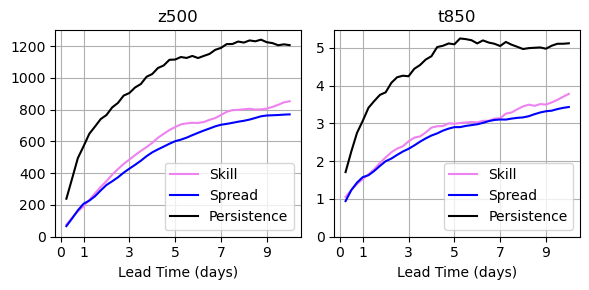

In [283]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
var_names = ['z500', 't850']

days = [t/24 for t in k_series]

def plot_axs(ax, var_ch):
    ax.plot(days, skill[:, var_ch], label='Skill',color='#EE82EE')
    ax.plot(days, spread[:, var_ch], label='Spread', color='#0000FF')
    ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k')
    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')
    ax.set_xticks([0,1,3,5, 7, 9])
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid('on')

plot_axs(axs[0], 0)
plot_axs(axs[1], 1)
plt.tight_layout()
#plt.savefig('figures/240906/skill_spread_6h.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

### Calculate long-term scores

In [25]:
wrmse_list = []
skill_list = []
spread_list = []
persistence_skill_list = []

In [29]:
forecast_fn= generate_ensemble_from_time_series
sampler_fn = heun_sampler

for i in tqdm(range(1)):
    forecast, truth, initial = forecast_fn(model, n_ens=10, selected_loader = val_time_series_loader, sampler_fn=sampler_fn)
    wrmse = calculate_WRMSE(forecast, truth)
    skill = calculate_WSkill(forecast, truth)
    spread = calculate_WSpread(forecast, truth)
    persistence_skill = calculate_WSkill(initial[:vars].unsqueeze(0), truth)

    wrmse_list.append(wrmse)
    skill_list.append(skill)
    spread_list.append(spread)
    persistence_skill_list.append(persistence_skill)

skill = torch.tensor(np.array(skill_list)).mean(axis=0)
spread = torch.tensor(np.array(spread_list)).mean(axis=0)
persistence_skill = torch.tensor(np.array(persistence_skill_list)).mean(axis=0)
wrmse = torch.tensor(np.array(wrmse_list)).mean(axis=0)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


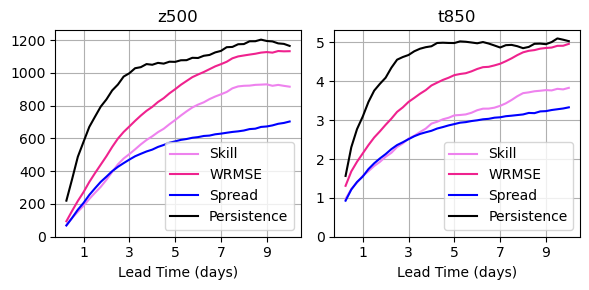

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
var_names = ['z500', 't850']

days = [t/24 for t in k_series]

def plot_axs(ax, var_ch):
    ax.plot(days, skill[:, var_ch], label='Skill',color='#EE82EE')
    ax.plot(days, wrmse[:, :, var_ch].mean(dim=0), label='WRMSE',color='#EF228E')
    ax.plot(days, spread[:, var_ch], label='Spread', color='#0000FF')
    ax.plot(days, persistence_skill[:, var_ch], label='Persistence', color='k')
    ax.set_title(var_names[var_ch])
    ax.set_xlabel('Lead Time (days)')
    ax.set_xticks([1,3,5, 7, 9])
    ax.set_ylim(bottom=0)
    ax.legend()
    ax.grid('on')

plot_axs(axs[0], 0)
plot_axs(axs[1], 1)
plt.tight_layout()
plt.savefig('figures/240906/skill_spread_dir_sing.png', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

### Ensemble Animation

In [284]:
var_ch = 1

time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[3]
dy = forecast.shape[4]

truth_plot = (truth[:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
forecast_plot = (forecast[:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

cmap_z = plt.cm.get_cmap('viridis') #, 20)     #t850
cmap_t = plt.cm.get_cmap('hot')     #, 35)     #t850

cmaps = [cmap_z, cmap_t]
cmap = cmaps[var_ch]

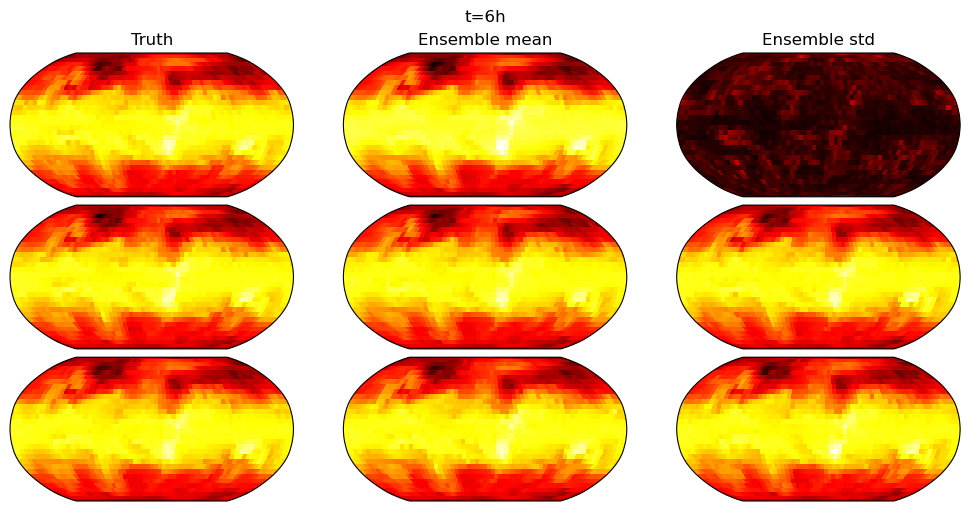

In [288]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
#fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        cf = ax.pcolormesh(lon, lat, truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max())
        images.append(cf)
        
    elif i == 1:
        cf = ax.pcolormesh(lon, lat, ens_mean[0], cmap=cmap, transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)

    elif i == 2:
        cf = ax.pcolormesh(lon, lat, ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max())
        images.append(cf)
        
    else:
        pass
        cf = ax.pcolormesh(lon, lat, forecast_plot[i-3,0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(forecast_plot[i-3,0], cmap=cmap, vmin=forecast_plot.min(), vmax=forecast_plot.max())
        images.append(cf)
        #ax.set_title(f'Sample #{i-2}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth_plot[n].flatten())
        elif i == 1:
            im.set_array(ens_mean[n].flatten())
        elif i == 2:
            im.set_array(ens_std[n].flatten())
        else:
            pass
            im.set_array(forecast_plot[i-3,n].flatten())

    txt_title.set_text(f't={time_labels[n].item()}h')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')
# 
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation_z500.gif', writer='imagemagick', fps=12)
HTML(anim.to_html5_video())

In [63]:
anim.save('figures/240905/ens-t850-dir.gif', writer='imagemagick', fps=60)

### Smaller Animation

In [286]:
time_labels=k_series

ens_ch = 0

dt = len(time_labels)
dx = forecast.shape[3]
dy = forecast.shape[4]

initial_plot_t850 = (initial[0,1]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]
initial_plot_z500 = (initial[0,0]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]

truth_plot_t850 = (truth[:,1]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
truth_plot_z500 = (truth[:,0]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]

forecast_plot_t850 = (forecast[:,:,1]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]
forecast_plot_z500 = (forecast[:,:,0]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

In [ ]:
truth_plot_t850 = (ar_forecast[0,:,1] - det_forecast[:,:,1]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
truth_plot_z500 = (ar_forecast[0,:,0] - det_forecast[:,:,0]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]

forecast_plot_t850 = (forecast[:,:,1] - det_forecast[:,:,1]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]
forecast_plot_z500 = (forecast[:,:,0] - det_forecast[:,:,0]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

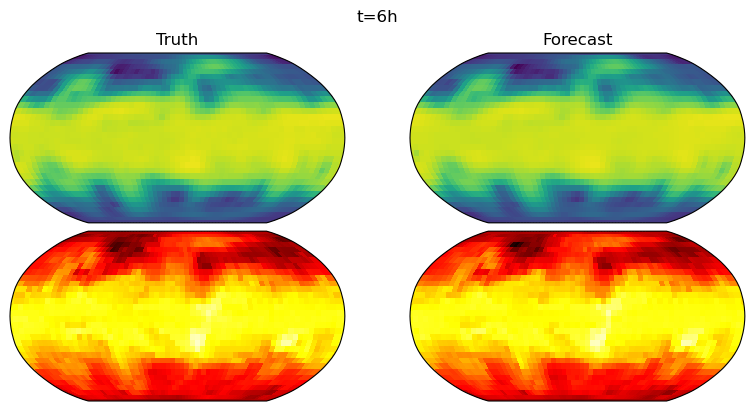

In [287]:
# Also animation but smaller
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML



# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(2, 2, figsize=(8, 4), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
#fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    #ax.axis('off')
    #ax.coastlines(resolution='110m', linewidth=0.5, color='k')
    #gridlines = ax.gridlines()
    #gridlines.linewidth = 0.5
    pass

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        cf = ax.pcolormesh(lon, lat, truth_plot_z500[0], cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max())
        images.append(cf)
        
    elif i == 1:
        cf = ax.pcolormesh(lon, lat, forecast_plot_z500[ens_ch, 0], cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_mean[0], cmap=cmap)
        images.append(cf)

    elif i == 2:
        cf = ax.pcolormesh(lon, lat, truth_plot_t850[0], cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max())
        images.append(cf)
        
    else:
        cf = ax.pcolormesh(lon, lat, forecast_plot_t850[ens_ch, 0], cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())

        #cf = ax.pcolormesh(lon, lat, forecast_plot[i-3,0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        #cf = ax.imshow(forecast_plot[i-3,0], cmap=cmap, vmin=forecast_plot.min(), vmax=forecast_plot.max())
        images.append(cf)
        #ax.set_title(f'Sample #{i-2}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth_plot_z500[n].flatten())
        elif i == 1:
            im.set_array(forecast_plot_z500[ens_ch, n].flatten())
        elif i == 2:
            im.set_array(truth_plot_t850[n].flatten())
        else:
            pass
            im.set_array(forecast_plot_t850[0, n].flatten())

    txt_title.set_text(f't={time_labels[n].item()}h')
    title1.set_text('Truth')
    title2.set_text('Forecast')
# 
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation_z500.gif', writer='imagemagick', fps=12)
HTML(anim.to_html5_video())

In [28]:
anim.save('figures/240906/det-iter.gif', writer='imagemagick', fps=50)

In [88]:
forecast=forecast_dir

### Temporal consistency

In [34]:
var_ch = 0

days = [t/24 for t in k_series[1:]]

dx_iter = ((forecast_ar[1:, 1:, var_ch] - forecast_ar[1:, :-1, var_ch])**2).mean(dim=(2,3)).sqrt().cpu().permute(1,0)
#different_latent = ((forecast[1:, 1:, var_ch] - forecast[:-1, :-1, var_ch])**2).mean(dim=(2,3)).sqrt().cpu().permute(1,0)
dx_dir = ((forecast_dir[1:, 1:, var_ch] - forecast_dir[1:, :-1, var_ch])**2).mean(dim=(2,3)).sqrt().cpu().permute(1,0)

dx_per = ((truth[1:, var_ch] - truth[:-1, var_ch])**2).mean(dim=(1,2)).sqrt().cpu()#.permute(1,0)

#print(same_latent.mean(), different_latent.mean())
plt.figure(figsize=(5,3))

plt.xlabel('Lead Time (days)')
plt.ylabel('RMS($X_{t+1}$, $X_t$)')
plt.xticks([1,3,5, 7, 9])

#plt.plot(different_latent, label = "Uncorrelated", color='#EE82EE')
plt.plot(days, dx_dir.mean(dim=1), label = "Direct", color='#EE82EE', linewidth=0.5)
plt.plot(days, dx_dir, color='#EE82EE', linewidth=0.5)

plt.plot(days, dx_iter.mean(dim=1), label = "Iterated", color='#0000FF', linewidth=0.5)
plt.plot(days, dx_iter, color='#0000FF', linewidth=0.5)

plt.plot(days, dx_per, label = "Persistence", color='k')#, linestyle='--')

plt.title('Temporal Coherence')

plt.legend()

#plt.savefig(f'figures/240905/temporal_coherence_1h.png', dpi=100, format='png', bbox_inches='tight')

NameError: name 'forecast_ar' is not defined

### GIF Generator

In [33]:
cmap_z = plt.cm.get_cmap('viridis', 50) #z500
cmap_t = plt.cm.get_cmap('hot', 50)     #t850

In [72]:
t_kmin = 6
t_kmax = 24*5
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=False)

forecast, truth, initial = generate_ensemble_from_time_series(model, n_ens=3, selected_loader = val_time_series_loader, sampler_fn=heun_sampler)
wrmse = calculate_WRMSE(forecast, truth)
skill = calculate_WSkill(forecast, truth)
spread = calculate_WSpread(forecast, truth)

In [73]:
time_labels=k_series

dt = len(time_labels)
dx = forecast.shape[3]
dy = forecast.shape[4]

var_ch = 1
truth_plot = (truth[:,var_ch]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
forecast_plot = (forecast[:,:,var_ch]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

ens_mean = forecast_plot.mean(axis=0)
ens_std = forecast_plot.std(axis=0)

In [27]:
initial_plot_t850 = (initial[0,1]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]
initial_plot_z500 = (initial[0,0]).cpu().detach().numpy().reshape((dx, dy))# - climatology[var_ch]

truth_plot_t850 = (truth[:,1]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]
truth_plot_z500 = (truth[:,0]).cpu().detach().numpy().reshape((-1, dx, dy))# - climatology[var_ch]

forecast_plot_t850 = (forecast[:,:,1]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]
forecast_plot_z500 = (forecast[:,:,0]).cpu().detach().numpy().reshape((forecast.shape[0], dt, dx,dy))# - climatology[var_ch]

In [28]:
import matplotlib.pyplot as plt

for i in range(dt):
    fig, axes = plt.subplots(2,1, figsize=(4,4.3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
    axes[0].pcolormesh(lon, lat, truth_plot_z500[i], cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
    axes[1].pcolormesh(lon, lat, truth_plot_t850[i], cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
 
    #plt.savefig(f'gifs/truth_z500/frame_{i+1}.png', bbox_inches='tight', pad_inches=0)
    plt.savefig(f'gifs/truth/frame_{i+1}.png', bbox_inches='tight', transparent=True, dpi=300)
    plt.close()

In [31]:
import matplotlib.pyplot as plt

ens = 2
folder = f'cont_{ens+1}'

for i in range(dt):
    fig, axes = plt.subplots(2,1, figsize=(4,4.3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
    axes[0].pcolormesh(lon, lat, forecast_plot_z500[ens, i], cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
    axes[1].pcolormesh(lon, lat, forecast_plot_t850[ens, i], cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())
 
    plt.savefig(f'gifs/{folder}/frame_{i+1}.png', bbox_inches='tight', transparent=True, dpi=300)
    plt.close()

In [32]:
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2,1, figsize=(4,4.3), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
axes[0].pcolormesh(lon, lat, initial_plot_z500, cmap=cmap_z, vmin=truth_plot_z500.min(), vmax=truth_plot_z500.max(), transform=ccrs.PlateCarree())
axes[1].pcolormesh(lon, lat, initial_plot_t850, cmap=cmap_t, vmin=truth_plot_t850.min(), vmax=truth_plot_t850.max(), transform=ccrs.PlateCarree())

#plt.savefig(f'gifs/truth_z500/frame_{i+1}.png', bbox_inches='tight', pad_inches=0)
plt.savefig(f'gifs/frame_0.png', bbox_inches='tight', transparent=True, dpi=300)
plt.close()

# Old Plots

#### **States**

##### **State:** Denoising of states over time

In [ ]:
fig, axes = plt.subplots(3,3, figsize=(15,10), constrained_layout=True, subplot_kw={'projection': ccrs.Robinson()})
cf = ax.pcolormesh(lon, lat, truth_plot[0], cmap=cmap, vmin=truth_plot.min(), vmax=truth_plot.max(), transform=ccrs.PlateCarree())
        

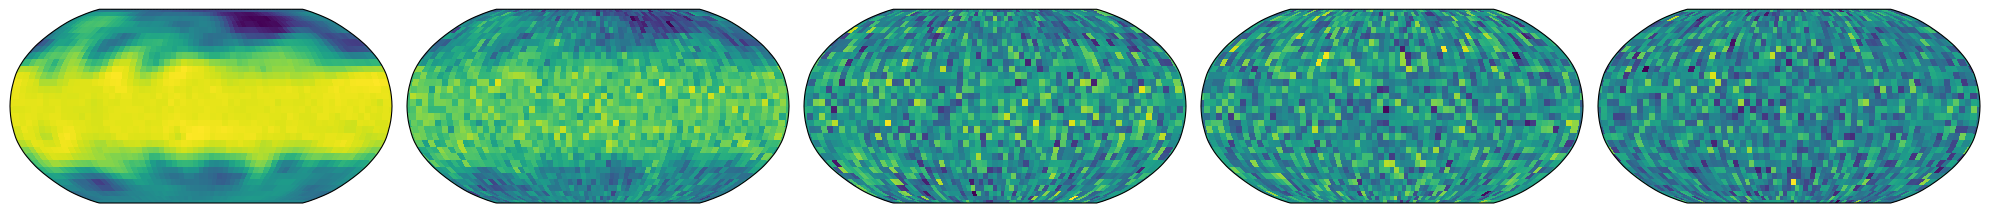

In [35]:
def plot_noising_of_states():
    """
    Plot the denoising of random states
    """
    image =  next(iter(train_loader))[0][0,0] #* std_data + mean_data

    noisy_images = []
    max_num = 5
    for i in range(max_num):

        rnd_uniform = 1 - i/(max_num-1)
        rho_inv = 1 / 7
        sigma_max_rho = 88 ** rho_inv
        sigma_min_rho = 0.02 ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

        weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

        noise = torch.randn_like(image)
        noisy_image = image + sigma * noise
        
        noisy_images.append(noisy_image.cpu().detach().numpy())

    fig, axes = plt.subplots(1, max_num, figsize=(20, 4), subplot_kw={'projection': ccrs.Robinson()})
    for i in range(max_num):
        axes[i].pcolormesh(lon, lat, noisy_images[i], cmap=cmap, transform=ccrs.PlateCarree())

    plt.tight_layout()

    plt.savefig('figures/noisy_images.png', format='png', bbox_inches='tight', dpi=300, transparent=True)
    plt.show()

plot_noising_of_states()

##### **State:** Autoencoder comparison

In [ ]:
image =  next(iter(train_loader))[0] #* std_data + mean_data

In [ ]:
encoded = autoencoder.encoder(image.to(device)).detach().cpu()
reconstruction = autoencoder.decoder(encoded.to(device)).detach().cpu()

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(reconstruction[0,0], cmap=cmap)
ax.axis('off')

plt.tight_layout()

plt.savefig('figures/reconstruction.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()


##### **State:** Removing noise from image

In [36]:
temp = next(iter(train_loader))
image = temp[1][0,0]
cond = temp[0][0,0]

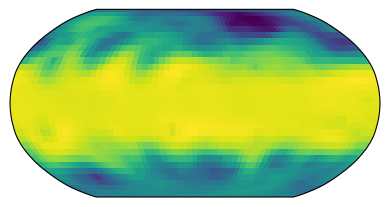

In [47]:
def plot_denoising_of_states():
    """
    Plot the denoising of random states
    """
    #image =  next(iter(train_loader))[0][0,0] #* std_data + mean_data

    noisy_images = []
    max_num = 6
    for i in range(max_num):

        rnd_uniform = 1 - i/(max_num-1)
        rho_inv = 1 / 7
        sigma_max_rho = 88 ** rho_inv
        sigma_min_rho = 0.02 ** rho_inv
        
        sigma = (sigma_max_rho + rnd_uniform * (sigma_min_rho - sigma_max_rho)) ** 7

        weight = (sigma ** 2 + 1 ** 2) / (sigma * 1) ** 2

        noise = torch.randn_like(image)
        noisy_image = image + sigma * noise
        
        noisy_images.append(noisy_image.cpu().detach().numpy())

    fig, axes = plt.subplots(1, 1, figsize=(4, 4), subplot_kw=dict(projection=ccrs.Robinson()))
    #plt_fn(axes,noisy_images[3])
    #axes.imshow(noisy_images[3] - noisy_images[0], cmap=cmap)
    axes.pcolormesh(lon, lat, noisy_images[0], cmap=cmap, transform=ccrs.PlateCarree())
    #axes.imshow(cond, cmap=cmap)
    #axes.axis('off')



    plt.tight_layout()
    plt.savefig('figures/cond.png', format='png', bbox_inches='tight', dpi=300, transparent=True)

    #plt.savefig('figures/noised.pdf', format='pdf', bbox_inches='tight', dpi=300)
    plt.show()

plot_denoising_of_states()

##### **State:** Standard plot of ensembles

In [ ]:
# Standard plot of ensembles

def ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=heun_sampler):
    
    lead_time = selected_loader.dataset.lead_time
    predicted_unnormalized, current_unnormalized, previous_unnormalized = generate_ensemble_from_single_random_noae(model, n_ens, selected_loader, sampler_fn=sampler_fn)

    ensemble_mean = predicted_unnormalized.mean(dim=0, keepdim=True)
    ensemble_rmses = calculate_RMSE(predicted_unnormalized, current_unnormalized).flatten()
    ensemble_skill = calculate_RMSE(ensemble_mean, current_unnormalized).item()
    ensemble_std = predicted_unnormalized.std(dim=0)

    best_forecast = predicted_unnormalized[np.argmin(ensemble_rmses)]
    best_rmse = ensemble_rmses[np.argmin(ensemble_rmses)]

    def plot_image(ax, image, title):
        image = image.cpu().detach().numpy().reshape((current_unnormalized.shape[2],current_unnormalized.shape[3]))
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')

    plt.set_cmap('viridis')
    no_ens_rows = 2

    fig, axes = plt.subplots(1+no_ens_rows, 5, figsize=(15, 10))
    fig.suptitle(f'{lead_time} step ahead prediction, {n_ens} ensemble members')

    plot_image(axes[0,0], previous_unnormalized, "Previous")
    plot_image(axes[0,1], current_unnormalized, "Truth")
    plot_image(axes[0,2], ensemble_mean, f"{ensemble_skill:.2f}\nEnsemble Mean")
    plot_image(axes[0,3], best_forecast, f"{best_rmse:.2f}\nBest forecast")
    plot_image(axes[0,4], ensemble_std, "Ensemble Std")

    count = 0
    for i in range(no_ens_rows):
        for j in range(5):
            plot_image(axes[1+i,j], predicted_unnormalized[count], f"{ensemble_rmses[count]:.2f}")
            count+=1
    
    plt.tight_layout()
    plt.show()
    
    return ensemble_rmses, ensemble_skill

val_dataset.set_lead_time(24*3)

ensemble_rmses, ensemble_skill = ensemble_plot(model, selected_loader=val_loader, n_ens=10, sampler_fn=heun_sampler)


In [ ]:
# We assume that the split results in same distance between all.
# Otherwise it becomes wrong when we flip it.

# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 0
t_kmax = 240
t_d = 24

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)

        current_last = current[-1].unsqueeze(0).repeat(current.shape[0]-1, 1, 1, 1)
        current_latent = autoencoder.encoder(current_last)

        time_labels = time_label[0].flip([0])[:-1].to(device)
        
        previous_latent = autoencoder.encoder(current[:-1])
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent

        current_unnormalized = current_last * std_data + mean_data

        break

In [ ]:
n_ens = 10

ensembles = []
with torch.no_grad():

    for i in tqdm(range(n_ens)):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


In [ ]:
import matplotlib.gridspec as gridspec

def plot_image(ax, image, title=None, vmin=None, vmax=None):
    image = image.cpu().detach().numpy().reshape((image.shape[1],image.shape[2]))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

no_ens_rows = ensembles.shape[1]

cols = 6 + 2
col_width_ratios = [1, 0, 1, 1, 1, 0, 1, 1]
gs = gridspec.GridSpec(no_ens_rows, cols, width_ratios=col_width_ratios)
fig = plt.figure(figsize=(15,15))

axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])

max_value = ensembles[:3].max()
min_value = ensembles[:3].min()

plot_image(axes[0,0], current_unnormalized[-1], "Truth", vmin=min_value, vmax=max_value)

for j in range(1, 4):
    axes[0,j+1].set_title(f"Sample #{j}")
axes[0,6].set_title("Ensemble Mean")
axes[0,7].set_title(f"Ensemble Std")


for i in range(no_ens_rows):
    if i > 0:
        axes[i,0].axis('off')
    axes[i,1].text(1.18,0.5, f"Forecast from\n {time_labels[-(i+1)].item()}t earlier", horizontalalignment='center', verticalalignment='center', rotation=90, transform=axes[i,0].transAxes)
    
    axes[i,1].axis('off')
    axes[i,5].axis('off')

    for j in range(1, 4):
        plot_image(axes[i,j+1], ensembles[j,-(i+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[i,6], ens_mean[-(i+1)], vmin=min_value, vmax=max_value)
    plot_image(axes[i,7], ens_std[-(i+1)], vmin=0, vmax=ens_std.max())


plt.savefig('figures/large_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()

##### **State:** Forecast over lead time

In [ ]:
t_kmin = 50
t_kmax = 150
t_d = 50

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):
        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 3

ensembles = []
with torch.no_grad():

    for i in tqdm(range(n_ens)):    
        latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling

        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))

        predicted_unnormalized = predicted * std_data + mean_data

        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)
ens_mean = ensembles.mean(dim=0)
ens_std = ensembles.std(dim=0)


In [ ]:
import matplotlib.gridspec as gridspec


def plot_image(ax, image, title=None, vmin=None, vmax=None):
    image = image.cpu().detach().numpy().reshape((image.shape[1],image.shape[2]))
    ax.imshow(image,vmin=vmin, vmax=vmax, cmap=cmap, interpolation='none')
    if title!=None:
        ax.set_title(title)
    #ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

def place_text(ax, text):
    ax.text(-0.1,0.5, text, horizontalalignment='center', verticalalignment='center', rotation=90, transform=ax.transAxes)

max_value = max([ensembles[:3].max(), current_unnormalized.max(), ens_mean.max()])
min_value = min([ensembles[:3].min(), current_unnormalized.min(), ens_mean.min()])

no_ens_rows =  ensembles.shape[1]

cols = current_unnormalized.shape[0]

gs = gridspec.GridSpec(no_ens_rows, cols)#, width_ratios=col_width_ratios)

fig = plt.figure(figsize=(15,15))#, constrained_layout=True)


axes = np.empty((no_ens_rows, cols), dtype=object)
for i in range(no_ens_rows):
    for j in range(cols):
        axes[i,j] = plt.subplot(gs[i,j])


place_text(axes[0,0], "Truth")
place_text(axes[1,0], "Sample #1")
place_text(axes[2,0], "Sample #2")
place_text(axes[3,0], "Sample #3")
place_text(axes[4,0], "Ensemble Mean")
place_text(axes[5,0], "Ensemble Std")

for i in range(cols):
    

    plot_image(axes[0,i], current_unnormalized[i], f't={time_labels[i]}', vmin=min_value, vmax=max_value)
    
    for j in range(1, 4):
        plot_image(axes[j, i], ensembles[j-1, i], vmin=min_value, vmax=max_value)
    
    plot_image(axes[4,i], ens_mean[i], vmin=min_value, vmax=max_value)
    plot_image(axes[5,i], ens_std[i], vmin=0, vmax=ens_std.max())


plt.savefig('figures/long_ensemble_plot.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)
plt.show()



In [ ]:
cond = previous_unnormalized.cpu().detach().numpy()[0,0]
forecast = ensembles[0,:,0].cpu().detach().numpy()

plt.figure(figsize=(5,5))

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.imshow(forecast[2], cmap=cmap)
axes.axis('off')

plt.tight_layout()

plt.savefig('figures/direct3.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

##### **State:** Iterative vs Direct Forecasting

In [ ]:
t_kmin = 10
t_kmax = 150
t_d = 10

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 3

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():
    start_time = time.time()
    for i in range(n_ens):
        # Direct  
        #latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)
    
    direct_time = time.time() - start_time
    # Autoreg
    latents = latents_list[:,0]
    prev_pred = class_labels[0].repeat(n_ens, 1, 1, 1)
    time_label = time_labels[0].repeat(n_ens)
    scale = residual_scaling(time_label).view(-1, 1, 1, 1)

    for i in range(roll_outs):
        predicted_ar_residuals = heun_sampler(model, latents, prev_pred, time_label/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_ar_latent = prev_pred + predicted_ar_residuals * scale
        
        predicted_ar = autoencoder.decoder(predicted_ar_latent.to(torch.float32))
        
        prev_pred = predicted_ar_latent
        
        predicted_unnormalized_ar = predicted_ar * std_data + mean_data
        ensembles_ar.append(predicted_unnormalized_ar)
    
    iterative_time = time.time() - start_time - direct_time

ensembles = torch.stack(ensembles)
ensembles_ar = torch.stack(ensembles_ar).permute(1,0,2,3,4)

print(f"Direct sampling time: {direct_time:.2f}s")
print(f"Iterative sampling time: {iterative_time:.2f}s")

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
cond = previous_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts_dir = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))
forecasts_ar = ensembles_ar.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean_dir = forecasts_dir.mean(axis=0)
ens_std_dir = forecasts_dir.std(axis=0)

ens_mean_ar = forecasts_ar.mean(axis=0)
ens_std_ar = forecasts_ar.std(axis=0)

In [ ]:
en = 0
ti = 2

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
#axes.imshow(forecasts_dir[en, ti], cmap=cmap)
axes.imshow(forecasts_ar[en, ti], cmap=cmap)
#axes.imshow(cond[0], cmap=cmap)
axes.axis('off')

plt.tight_layout()

plt.savefig(f'figures/iterative3.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
cond.shape

In [ ]:
en = 2

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.axis('off')
plt.tight_layout()

for ti in range(len(time_labels)):
    #axes.imshow(forecasts_ar[en, ti], cmap=cmap)
    axes.imshow(truth[ti], cmap=cmap)
    pass
    plt.savefig(f'gifs/truth/truth-{ti+1}.pdf', format='pdf', bbox_inches='tight', dpi=300)

#axes.imshow(cond[0], cmap=cmap)

#plt.savefig(f'gifs/truth/truth-{0}.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.show()

In [ ]:
en = 2

fig, axes = plt.subplots(1, 1, figsize=(4, 4))
axes.axis('off')
plt.tight_layout()

axes.imshow(cond[0], cmap=cmap)

#plt.savefig(f'figures/an_dir.pdf', format='pdf', bbox_inches='tight', dpi=300)
#plt.show()

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean_ar[0]))
    elif i == 2:
        images.append(ax.imshow(ens_mean_dir[0], cmap=cmap))
    elif i <=5:
        images.append(ax.imshow(forecasts_dir[i-3,0], cmap=cmap))
        ax.set_title(f'Direct #{i-2}')
    else:
        images.append(ax.imshow(forecasts_ar[i-6,0], cmap=cmap))
        ax.set_title(f'Iterative #{i-5}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean_ar[n])
        elif i == 2:
            im.set_array(ens_mean_dir[n])
        elif i < 6:
            im.set_array(forecasts_dir[i-3,n])
        else:
            im.set_array(forecasts_ar[i-6,n])


    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble Mean Iterative')
    title3.set_text('Ensemble Mean Direct')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

#### **Plot**

##### **Plot:** RMSE over time

In [ ]:
def rmse_plot(model, n_ens=1, n_batches=1, selected_loader=val_loader, sampler_fn=heun_sampler):
    model.eval()

    result = {}
    result['rmse_model'] = np.zeros(n_batches*batch_size)
    result['rmse_clim'] = np.zeros(n_batches*batch_size)

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader)):
            current = current.to(device)
            time_label = time_label.to(device)
            if count >= n_batches:
                break

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=sampler_fn)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            #  Note that this is kind of cheating since we are using the validation set to calculate the climatology.
            #  More realistic if we have a larger batch size.
            #climatology = previous_unnormalized.mean(dim=0, keepdim=True)

            ensemble_mean = predicted_unnormalized.mean(dim=0)

            rmse_model = calculate_RMSE(ensemble_mean, current_unnormalized)
            rmse_clim = calculate_RMSE(climatology, current_unnormalized)

            result['rmse_model'][count*batch_size:count*batch_size+rmse_model.size] = rmse_model.flatten()
            result['rmse_clim'][count*batch_size:count*batch_size+rmse_model.size] = rmse_clim.flatten()

    return result

In [ ]:
lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **QG_kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_batches = 1

# NWP

n_val = 210000
nwp_data_path = Path(f'/nobackup/smhid20/users/sm_maran/dpr_data/simulations/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy') if on_remote else Path(f'C:/Users/svart/Desktop/MEX/data/QG_samples_LRES_{iterations}_n_{n_val}_k_{lead_time}.npy')
nwp_dataset = NWPDataset(nwp_data_path, n_val=n_val, spacing=spacing, device=device)
nwp_loader = DataLoader(nwp_dataset, batch_size=batch_size, shuffle=False)
nwp_skill = calculate_nwp_skill(n_batches=n_batches)

# Climate and skill
climatology = calculate_climatology(train_loader, n_batches=n_batches)

n_ens = 10
running_mean = 100

result = rmse_plot(model, n_ens, n_batches, selected_loader=val_loader, sampler_fn=heun_sampler)

rmse_model, rmse_clim = result['rmse_model'], result['rmse_clim']
rmse_nwp = nwp_skill[:n_batches*batch_size]

plt.figure(figsize=(5,5))
plt.title(f'{lead_time} step ahead prediction, {n_ens} ensemble members')
plt.plot(uniform_filter1d(rmse_model, size=running_mean), label='Ensemble Mean', color='b')
plt.plot(uniform_filter1d(rmse_clim, size=running_mean), label='Climatology', color='r')
plt.plot(uniform_filter1d(rmse_nwp, size=running_mean), label='NWP', color='g')
plt.ylim(0,11)
plt.xlabel('Time', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
def rmse_density_plot(ensemble_rmses, ensemble_skill):
    plt.figure(figsize=(6,6))
    plt.hist(ensemble_rmses, bins=100)
    plt.axvline(ensemble_skill, color='red', linestyle='--')
    plt.xlabel('Ensemble RMSEs')
    plt.ylabel('Density')
    plt.title('Density Plot of Ensemble RMSEs')
    plt.show()

rmse_density_plot(ensemble_rmses, ensemble_skill)

##### **Plot:** Spread vs time

In [ ]:
# Fixed k sampling
# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 6
t_kmax = 24*5
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

n_batches = 10

spread_list = []
skill_list = []
ratio_list = []
wrmses_list = []
persistence_list = []


for i in tqdm(range(n_batches)):
        
    model.eval()  # Set model to evaluation mode

    n_ens = 10

    with torch.no_grad():
        for previous, current, time_label in (val_time_series_loader):
            current = current.to(device).permute(1,0,2,3)
            previous = previous.to(device)

            #current_latent = autoencoder.encoder(current)
            current_latent = current
            time_labels = time_label[0].to(device)
            
            #previous_latent = autoencoder.encoder(previous)
            previous_latent = previous

            previous_latent = previous[:,0].unsqueeze(1)
            scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
            target_latent =  (current_latent)# - previous_latent) / scaling
            
            class_labels = previous.repeat(current.shape[0], 1, 1, 1)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            break


    ensembles = []
    with torch.no_grad():
        for i in (range(n_ens)):    
            latents = torch.randn_like(previous_latent[0].unsqueeze(0), device=device).repeat(current.shape[0], 1, 1, 1)

            predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
            predicted_latent = predicted_residuals # * scaling + previous_latent

            #predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
            predicted = predicted_latent
            predicted_unnormalized = predicted * std_data + mean_data

            ensembles.append(predicted_unnormalized)

    ensembles = torch.stack(ensembles)
    ens_mean = ensembles.mean(dim=0)


    spreads = []
    skills = []
    wrmses = []
    persistences = []

    for i in range(len(time_labels)):
        truth = current_unnormalized[i]
        predicted = ens_mean[i]
        ensemble = ensembles[:, i]
        
        # Mew
        wrmse = calculate_WRMSE(ensemble, truth)
        wrmse = np.mean(wrmse)
        
        skill = calculate_WRMSE(ensemble.mean(dim=0, keepdim=True), truth)
        spread = calculate_WSpread(ensemble, truth)
        wrmses.append(wrmse)
        #skills.append(skill)
        #spreads.append(spread)

        p_wrmse = calculate_WRMSE(previous_unnormalized.unsqueeze(0), truth)
        persistences.append(p_wrmse[0])
    

        # old
        #skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
        spreads.append(spread[0])
        skills.append(skill[0])
    
    spread_list.append(spreads)
    skill_list.append(skills)
    ratio_list.append(np.array(spreads)/np.array(skills))
    wrmses_list.append(wrmses)
    persistence_list.append(persistences)

spread_list = np.array(spread_list)
skill_list = np.array(skill_list)
ratio_list = np.array(ratio_list)
wrmses_list = np.array(wrmses_list)
persistence_list = np.array(persistence_list)
time_labels = time_labels.cpu().detach().numpy()

In [ ]:
spreads = spread_list.mean(axis=0)
skills = skill_list.mean(axis=0)
wrmses = wrmses_list.mean(axis=0)
persistences = persistence_list.mean(axis=0)

plt.figure(figsize=(5/1.2,3/1.2))
plt.xlabel('Lead time (days)')
plt.grid('on')

#plt.xticks([0,50,100,150])
plt.xticks([0,24,48,72, 24*4, 24*5, 24*6, 24*7])
#plt.xlim([-10,160])
#plt.yticks([0,2,4,6])
#plt.ylim(0-0.3, 6+0.3)

days = [t/24 for t in time_labels]
plt.xticks([1, 2, 3, 4, 5])
plt.yticks([0,200,400,600,800,1000,1200])


plt.plot(days, uniform_filter1d(spreads, size=1), label='Spread', color='#0000FF')
plt.plot(days, uniform_filter1d(skills, size=1), label='Skill', color='#EE82EE')
plt.plot(days, uniform_filter1d(wrmses, size=1), label='Avg WRMSE', color='#EE82EE', linestyle='dashed')
plt.plot(days, uniform_filter1d(persistences, size=1), label='Persistence', color='k')

plt.legend()

plt.savefig(f'figures/skill_spread_{lead_time}_{n_ens}.pdf', dpi=100, format='pdf', bbox_inches='tight')

##### **Plot:** Rank Histogram

In [ ]:
def generate_ensembles(n_ens, n_batches, selected_loader=val_loader):
    model.eval()

    ensembles = []
    truths = []

    with torch.no_grad():
        for count, (previous, current, time_label) in enumerate(tqdm(selected_loader, total=n_batches)):
            if count >= n_batches:
                break
            current = current.to(device)

            predicted_unnormalized = generate_ensemble_from_batch(model, previous, time_label[0], n_ens=n_ens, sampler_fn=heun_sampler)
            current_unnormalized = current * std_data + mean_data

            ensembles.append(predicted_unnormalized)
            truths.append(current_unnormalized)

    ensembles = torch.cat(ensembles, dim=1)
    truths = torch.cat(truths, dim=0)
    return ensembles, truths


lead_time = 150
batch_size = 16
val_dataset = QGDataset(lead_time=lead_time, dataset_mode='val', **kwargs)
val_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

n_ens = 1
n_batches = 1

ensembles, truths = generate_ensembles(n_ens, n_batches, selected_loader=val_loader)

In [ ]:
# Rank Histogram

def calculate_rank(predicted, target):
    ranks = (target[None, :] < predicted).sum(axis=0)
    return ranks

def rank_histogram(pixel, ensembles, truths):

    pixel_x, pixel_y = pixel
    
    ensemble = ensembles[:, :, 0, pixel_x, pixel_y]
    target = truths[:, 0, pixel_x, pixel_y]

    rank = calculate_rank(ensemble, target)

    return rank.cpu().detach().numpy()

In [ ]:
# New look

ranks = np.zeros(n_ens+1)
for i in range(0, truths.shape[2]):
    for j in range(0, truths.shape[3]):
        pixel = (i,j)
        rank = rank_histogram(pixel, ensembles, truths)
        freq = np.bincount(rank, minlength=n_ens+1)
        ranks += freq

print(f'{n_ens} members, {n_batches*batch_size} samples')
plt.figure(figsize=(3,3))
plt.title(f'k={lead_time}')
plt.plot(np.linspace(0,1,n_ens+1), ranks*(n_ens+1)/(sum(ranks)), color='black')
plt.xlabel('Rank (normalized)')
plt.ylabel('Frequency')
plt.ylim(-0.1,2.1)
plt.yticks([0,0.5,1,1.5,2])
plt.xticks([0,0.25,0.5,0.75,1])
plt.axhline(1, color='k', linestyle='--', alpha=0.5)

plt.savefig(f'figures/rank_histogram_{lead_time}_{n_ens}_{n_batches*batch_size}.pdf', dpi=100, format='pdf', bbox_inches='tight')#, pad_inches=0.1, transparent=True, quality=95, optimize=True)

In [ ]:
pixel = (np.random.randint(0, truths.shape[2]), np.random.randint(0, truths.shape[3]))
print(pixel)
#pixel = (1,33)
ranks = np.zeros(n_ens+1)
rank = rank_histogram(pixel, ensembles, truths)
freq = np.bincount(rank, minlength=n_ens+1)
ranks += freq

plt.figure(figsize=(4,4))
plt.title(f'{lead_time} lead time, {n_ens} members, {n_batches*batch_size} samples')
plt.bar(np.arange(n_ens+1), ranks/(sum(ranks)), facecolor='white', edgecolor='black')
plt.axhline(1/(n_ens+1), color='k', linestyle='--')

##### **Plot:** Temporal consistency evaluation

In [ ]:
# Fixed k sampling
# Way to load a single trajectory. Only uses 1 batch.
t_kmin = 6
t_kmax = 120
t_d = 6
k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

n_batches = 1

spread_list = []
skill_list = []
ratio_list = []

for i in (range(n_batches)):
        
    model.eval()  # Set model to evaluation mode

    n_ens = 10

    with torch.no_grad():
        for previous, current, time_label in (val_time_series_loader):
            current = current.to(device).permute(1,0,2,3)
            previous = previous.to(device)

            current_latent = current#autoencoder.encoder(current)

            time_labels = time_label[0].to(device)
            
            previous_latent = previous#autoencoder.encoder(previous)
            
            scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
            target_latent =  (current_latent - previous_latent) / scaling
            
            class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

            current_unnormalized = current * std_data + mean_data
            previous_unnormalized = previous * std_data + mean_data

            break


    ensembles = []
    with torch.no_grad():
        for i in tqdm(range(n_ens)):    
            latents = torch.randn_like(class_labels[0].unsqueeze(0), device=device).repeat(class_labels.shape[0], 1, 1, 1)

            predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
            predicted_latent = previous_latent + predicted_residuals * scaling

            predicted = predicted_latent#autoencoder.decoder(predicted_latent.to(torch.float32))

            predicted_unnormalized = predicted * std_data + mean_data

            ensembles.append(predicted_unnormalized)

    ensembles = torch.stack(ensembles)
    ens_mean = ensembles.mean(dim=0)


    spreads = []
    skills = []

    for i in range(len(time_labels)):
        truth = current_unnormalized[i]
        predicted = ens_mean[i]
        ensemble = ensembles[:, i]

        skill, spread,_ = calculate_skill_and_spread_score(ensemble, truth)
        spreads.append(spread[0])
        skills.append(skill[0])
    
    spread_list.append(spreads)
    skill_list.append(skills)
    ratio_list.append(np.array(spreads)/np.array(skills))

spread_list = np.array(spread_list)
skill_list = np.array(skill_list)
ratio_list = np.array(ratio_list)
time_labels = time_labels.cpu().detach().numpy()

In [ ]:
same_latent = ((ensembles[1:, 1:] - ensembles[1:, :-1])**2).mean(dim=(2,3,4)).sqrt().cpu().permute(1,0)
different_latent = ((ensembles[1:, 1:] - ensembles[:-1, :-1])**2).mean(dim=(2,3,4)).sqrt().cpu().permute(1,0)

print(same_latent.mean(), different_latent.mean())

In [ ]:
plt.figure(figsize=(3,3))

plt.xlabel('Lead time')
plt.ylabel('RMS($X_{t+1}$, $X_t$)')

#plt.xticks([0,50,100,150])
#plt.xlim([-10,160])
#plt.yticks([0,2,4,6])
#plt.ylim(0-0.3, 6+0.3)

#plt.plot(different_latent, label = "Uncorrelated", color='#EE82EE')
plt.plot(same_latent.mean(dim=1), label = "DEFfusion", color='#0000FF')

#plt.legend(loc='upper left')

plt.savefig(f'figures/temporal_coherence.pdf', dpi=100, format='pdf', bbox_inches='tight')

#### **Animation**

##### **Animation:** Direct forecasting

In [ ]:
t_kmin = 6
t_kmax = 24*5
t_d = 6

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        #current_latent = autoencoder.encoder(current)
        current_latent = current
        time_labels = time_label[0].to(device)
        #previous_latent = autoencoder.encoder(previous)
        previous_latent = previous[:,0].unsqueeze(1)
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        #target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current #* std_data + mean_data
        previous_unnormalized = previous_latent #* std_data + mean_data

        break

In [ ]:
n_ens = 6

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(previous_latent[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in tqdm(range(n_ens)):
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = predicted_residuals# * scaling + previous_latent
        #predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted = predicted_latent
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean = forecasts.mean(axis=0)
ens_std = forecasts.std(axis=0)

In [ ]:
truth = (current_unnormalized - previous_unnormalized).cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = (ensembles- previous_unnormalized).cpu().detach().numpy().reshape((n_ens, dt, dx,dy))


In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

cmap = plt.cm.get_cmap('viridis', 40)


# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,5), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap, vmin=truth.min(), vmax=truth.max()))
    elif i == 1:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i == 2:
        images.append(ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max()))
    else:
        images.append(ax.imshow(forecasts[i-3,0], cmap=cmap, vmin=forecasts.min(), vmax=forecasts.max()))
        ax.set_title(f'Sample #{i-2}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean[n])
        elif i == 2:
            im.set_array(ens_std[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')
# 
    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation.gif', writer='imagemagick', fps=12)
HTML(anim.to_html5_video())

In [ ]:
anim.save('figures/animation_large_6h.gif', writer='imagemagick', fps=12)


In [ ]:
anim.save('figures/animation.gif', writer='imagemagick', fps=24)

##### **Animation:** Truth

In [ ]:
t_kmin = 1
t_kmax = 240
t_d = 1

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)

        time_labels = time_label[0].to(device)
        
        current_unnormalized = current * std_data + mean_data

        residual = current#autoencoder.encoder(current) - autoencoder.encoder(previous.to(device))
        break

In [ ]:
truth = residual[:,0].cpu().detach().numpy().reshape((-1, 16, 32))
truth.shape


In [ ]:
dt = len(time_labels)
dx = current_unnormalized.shape[2]
dy = current_unnormalized.shape[3]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))

#truth = residual.cpu().detach().numpy().reshape((-1, dx, dy))


In [ ]:
%matplotlib inline

cmap = plt.cm.get_cmap('hot')

from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, ax = plt.subplots(1,1, figsize=(6,3), constrained_layout=True)

txt_title = fig.suptitle('', va='top')

ax.axis('off')

title1 = ax.set_title('')

images = []
im = (ax.imshow(truth[0], cmap=cmap, vmin=truth.min(), vmax=truth.max()))        


# animation function. This is called sequentially
def drawframe(n):
    
    im.set_array(truth[n])
        
    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=50)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

In [ ]:
import matplotlib.pyplot as plt

for i in range(dt):
    plt.imshow(truth[i], cmap=cmap)
    plt.axis('off')
    plt.savefig(f'gifs/frame_{i+1}.png', bbox_inches='tight', pad_inches=0)
    plt.close()

##### **Animation:** Iterative vs Direct Forecasting

In [ ]:
t_kmin = 10
t_kmax = 150
t_d = 10

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 15

latents_list = []
ensembles_list = []

for i in range(n_ens): 
    latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
    latents_list.append(latents)

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():
    start_time = time.time()
    for i in range(n_ens):
        # Direct  
        #latents = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)
    
    direct_time = time.time() - start_time
    # Autoreg
    latents = latents_list[:,0]
    prev_pred = class_labels[0].repeat(n_ens, 1, 1, 1)
    time_label = time_labels[0].repeat(n_ens)
    scale = residual_scaling(time_label).view(-1, 1, 1, 1)

    for i in range(roll_outs):
        predicted_ar_residuals = heun_sampler(model, latents, prev_pred, time_label/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_ar_latent = prev_pred + predicted_ar_residuals * scale
        
        predicted_ar = autoencoder.decoder(predicted_ar_latent.to(torch.float32))
        
        prev_pred = predicted_ar_latent
        
        predicted_unnormalized_ar = predicted_ar * std_data + mean_data
        ensembles_ar.append(predicted_unnormalized_ar)
    
    iterative_time = time.time() - start_time - direct_time

ensembles = torch.stack(ensembles)
ensembles_ar = torch.stack(ensembles_ar).permute(1,0,2,3,4)

print(f"Direct sampling time: {direct_time:.2f}s")
print(f"Iterative sampling time: {iterative_time:.2f}s")

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts_dir = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))
forecasts_ar = ensembles_ar.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean_dir = forecasts_dir.mean(axis=0)
ens_std_dir = forecasts_dir.std(axis=0)

ens_mean_ar = forecasts_ar.mean(axis=0)
ens_std_ar = forecasts_ar.std(axis=0)

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean_ar[0]))
    elif i == 2:
        images.append(ax.imshow(ens_mean_dir[0], cmap=cmap))
    elif i <=5:
        images.append(ax.imshow(forecasts_dir[i-3,0], cmap=cmap))
        ax.set_title(f'Direct #{i-2}')
    else:
        images.append(ax.imshow(forecasts_ar[i-6,0], cmap=cmap))
        ax.set_title(f'Iterative #{i-5}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            pass
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean_ar[n])
        elif i == 2:
            im.set_array(ens_mean_dir[n])
        elif i < 6:
            im.set_array(forecasts_dir[i-3,n])
        else:
            im.set_array(forecasts_ar[i-6,n])


    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble Mean Iterative')
    title3.set_text('Ensemble Mean Direct')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=100)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())

##### **Animation:** Interpolation between latent states

In [ ]:
t_kmin = 1
t_kmax = 150
t_d = 1

k_series = t_kmin + t_d * np.arange(0, 1 + (t_kmax-t_kmin)//t_d)
val_time_series_dataset = QGDataset(lead_time=k_series, dataset_mode='val', **kwargs)
val_time_series_loader = DataLoader(val_time_series_dataset, batch_size=1, shuffle=True)

model.eval()  # Set model to evaluation mode


with torch.no_grad():
    for previous, current, time_label in (val_time_series_loader):

        current = current.to(device).permute(1,0,2,3)
        previous = previous.to(device)

        current_latent = autoencoder.encoder(current)

        time_labels = time_label[0].to(device)
        previous_latent = autoencoder.encoder(previous)
        
        scaling = residual_scaling(time_labels).view(-1, 1, 1, 1)
        target_latent =  (current_latent - previous_latent) / scaling
        
        class_labels = previous_latent.repeat(current.shape[0], 1, 1, 1)

        current_unnormalized = current * std_data + mean_data
        previous_unnormalized = previous * std_data + mean_data

        break

In [ ]:
n_ens = 6

latents1 = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)
latents2 = torch.randn_like(class_labels[0], device=device).repeat(class_labels.shape[0], 1, 1, 1)

alphas = np.linspace(0, 1, n_ens)

def interpolate_latents(alpha):
    return np.sqrt(1-alpha)*latents1 + np.sqrt(alpha)*latents2

latents_list = []

for alpha in alphas:
    latents_list.append(interpolate_latents(alpha))

latents_list = torch.stack(latents_list)

In [ ]:
roll_outs = len(time_labels)

ensembles = []
ensembles_ar = []
with torch.no_grad():

    for i in range(n_ens):
        latents = latents_list[i]
        predicted_residuals = heun_sampler(model, latents, class_labels, time_labels/max_lead_time, sigma_max=80, sigma_min=0.03, rho=7, num_steps=20)
        predicted_latent = previous_latent + predicted_residuals * scaling
        predicted = autoencoder.decoder(predicted_latent.to(torch.float32))
        predicted_unnormalized = predicted * std_data + mean_data
        ensembles.append(predicted_unnormalized)

ensembles = torch.stack(ensembles)

In [ ]:
dt = len(time_labels)
dx = ensembles.shape[3]
dy = ensembles.shape[4]

truth = current_unnormalized.cpu().detach().numpy().reshape((-1, dx, dy))
forecasts = ensembles.cpu().detach().numpy().reshape((n_ens, dt, dx,dy))

ens_mean = forecasts.mean(axis=0)
ens_std = forecasts.std(axis=0)

In [ ]:
%matplotlib inline
from matplotlib import rc
from matplotlib import animation
from IPython.display import HTML

# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

fig, axes = plt.subplots(3,3, figsize=(10,11), constrained_layout=True)

txt_title = fig.suptitle('', va='top')
for ax in axes.flatten():
    ax.axis('off')

title1 = axes[0,0].set_title('')
title2 = axes[0,1].set_title('')
title3 = axes[0,2].set_title('')

images = []
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        pass
        images.append(ax.imshow(truth[0], cmap=cmap))
    elif i == 1:
        images.append(ax.imshow(ens_mean[0], cmap=cmap))
    elif i == 2:
        images.append(ax.imshow(ens_std[0], cmap=cmap, vmin=0, vmax=ens_std.max()))
    else:
        images.append(ax.imshow(forecasts[i-3,0], cmap=cmap))
        ax.set_title(f'alpha = {alphas[i-3]}')

# animation function. This is called sequentially
def drawframe(n):
    for i, im in enumerate(images):
        if i == 0:
            im.set_array(truth[n])
        elif i == 1:
            im.set_array(ens_mean[n])
        elif i == 2:
            im.set_array(ens_std[n])
        else:
            im.set_array(forecasts[i-3,n])

    txt_title.set_text(f't={time_labels[n].item()}')
    title1.set_text('Truth')
    title2.set_text('Ensemble mean')
    title3.set_text('Ensemble std')

    return images

anim = animation.FuncAnimation(fig, drawframe, frames=dt, interval=50)

#anim.save('figures/animation.gif', writer='imagemagick', fps=30)
HTML(anim.to_html5_video())